## Problem Statement

- Backorders are unavoidable, but by anticipating which things will be backordered,
planning can be streamlined at several levels, preventing unexpected strain on
production, logistics, and transportation. 
- ERP systems generate a lot of data (mainly structured) and also contain a lot of historical data; if this data can be properly utilized, a predictive model to forecast backorders and plan accordingly can be constructed.
- Based on past data from inventories, supply chain, and sales, classify the products as
going into backorder (Yes or No).

- The Problem is to prevent the unexpected strain on production,logistcs and transportation.
- From then problem statement we need reduce the both False Positve and False Negative.
    - False Negative reduction will help us to prevent the unexpected strain on production,logistics and transportation
    - False positive is not that much important to the company because even if it is predicted as product is going to be backordered but actually is not backorded.

## Description about features in Dataset

- sku - Random ID for the product
- national_inv - Current inventory level for the part
- lead_time - Transit time for product (if available)
- in_transit_qty - Amount of product in transit from source
- forecast_3_month - Forecast sales for the next 3 months
- forecast_6_month - Forecast sales for the next 6 months
- forecast_9_month - Forecast sales for the next 9 months
- sales_1_month - Sales quantity for the prior 1 month time period
- sales_3_month - Sales quantity for the prior 3 month time period
- sales_6_month - Sales quantity for the prior 6 month time period
- sales_9_month - Sales quantity for the prior 9 month time period
- min_bank - Minimum recommend amount to stock
- potential_issue - Source issue for part identified
- pieces_past_due - Parts overdue from source
- perf_6_month_avg - Source performance for prior 6 month period
- perf_12_month_avg - Source performance for prior 12 month period
- local_bo_qty - Amount of stock orders overdue
- deck_risk - Part risk flag
- oe_constraint - Part risk flag
- ppap_risk - Part risk flag
- stop_auto_buy - Part risk flag
- rev_stop - Part risk flag
- went_on_backorder - Product actually went on backorder. This is the target value.

## Importing Required libraries

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import RobustScaler,LabelEncoder
from sklearn.impute import SimpleImputer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [3]:

dataset:pd.DataFrame = pd.read_parquet('/config/workspace/sample_bo.parquet.gzip')

# Displaying top 5 rows

dataset.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
732013,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.98,0.98,0.0,No,No,Yes,Yes,No,No
38200,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.70,0.75,0.0,No,No,No,Yes,No,No
1145713,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,0.0,0.92,0.96,0.0,Yes,No,Yes,Yes,No,No
1080013,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,No,0.0,0.62,0.62,0.0,Yes,No,No,Yes,No,No
1264726,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,No,No,No


In [4]:
dataset.reset_index(inplace=True,drop=True)

In [5]:
# Checking the shape of the dataset

dataset.shape

(500000, 22)

In [6]:
dataset.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.98,0.98,0.0,No,No,Yes,Yes,No,No
1,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.70,0.75,0.0,No,No,No,Yes,No,No
2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,0.0,0.92,0.96,0.0,Yes,No,Yes,Yes,No,No
3,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,No,0.0,0.62,0.62,0.0,Yes,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,No,No,No


In [7]:
# diplaying column names

dataset.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [8]:
# dataset information

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   national_inv       499999 non-null  float64
 1   lead_time          470155 non-null  float64
 2   in_transit_qty     499999 non-null  float64
 3   forecast_3_month   499999 non-null  float64
 4   forecast_6_month   499999 non-null  float64
 5   forecast_9_month   499999 non-null  float64
 6   sales_1_month      499999 non-null  float64
 7   sales_3_month      499999 non-null  float64
 8   sales_6_month      499999 non-null  float64
 9   sales_9_month      499999 non-null  float64
 10  min_bank           499999 non-null  float64
 11  potential_issue    499999 non-null  object 
 12  pieces_past_due    499999 non-null  float64
 13  perf_6_month_avg   499999 non-null  float64
 14  perf_12_month_avg  499999 non-null  float64
 15  local_bo_qty       499999 non-null  float64
 16  de

In [9]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype !='O']
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features]

print(f"Number of numerical features {len(numerical_features)}.\nNumerical features are \n {numerical_features}")
print(f"Number of Categorical features {len(categorical_features)}. \nCategorical features are \n {categorical_features}")

Number of numerical features 15.
Numerical features are 
 ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']
Number of Categorical features 7. 
Categorical features are 
 ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [10]:
# checking and dropping the duplicates

print("Number of duplicate values ",dataset.duplicated().sum())

# dropping duplicates

dataset.drop_duplicates(inplace=True)

# After dropping duplicates
print("After droppping Number of duplicate values ",dataset.duplicated().sum())

# After dropping duplicates the shape of the data
print('Shape of dataset ',dataset.shape)


Number of duplicate values  141544
After droppping Number of duplicate values  0
Shape of dataset  (358456, 22)


- As we can observe there are no duplicate values are there in the dataset.

In [11]:
# Checking for null values

dataset.isnull().sum()

national_inv             1
lead_time            15585
in_transit_qty           1
forecast_3_month         1
forecast_6_month         1
forecast_9_month         1
sales_1_month            1
sales_3_month            1
sales_6_month            1
sales_9_month            1
min_bank                 1
potential_issue          1
pieces_past_due          1
perf_6_month_avg         1
perf_12_month_avg        1
local_bo_qty             1
deck_risk                1
oe_constraint            1
ppap_risk                1
stop_auto_buy            1
rev_stop                 1
went_on_backorder        1
dtype: int64

In [12]:
# As we can observe there is one row with all null values

# we can drop the row with more than 10 null values

dataset.dropna(thresh=10,inplace=True)
dataset.isnull().sum()

national_inv             0
lead_time            15584
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
stop_auto_buy            0
rev_stop                 0
went_on_backorder        0
dtype: int64

In [20]:
dataset.shape

(358455, 22)

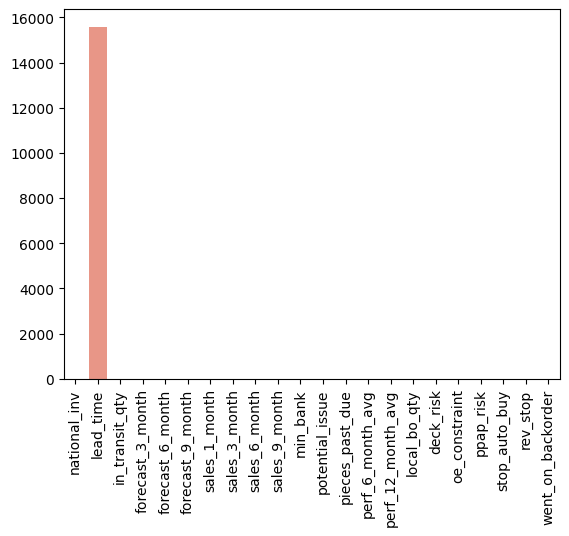

In [30]:
null_values = {feature:dataset[feature].isnull().sum() for feature in dataset.columns}
sns.barplot(x=list(null_values.keys()),y=list(null_values.values()))
plt.title= "NUll value frequency"
plt.xlabel='Features'
plt.ylabel='Count'
plt.xticks(rotation=90)
plt.show()


### Observation
 - Only lead_time has high nan values.

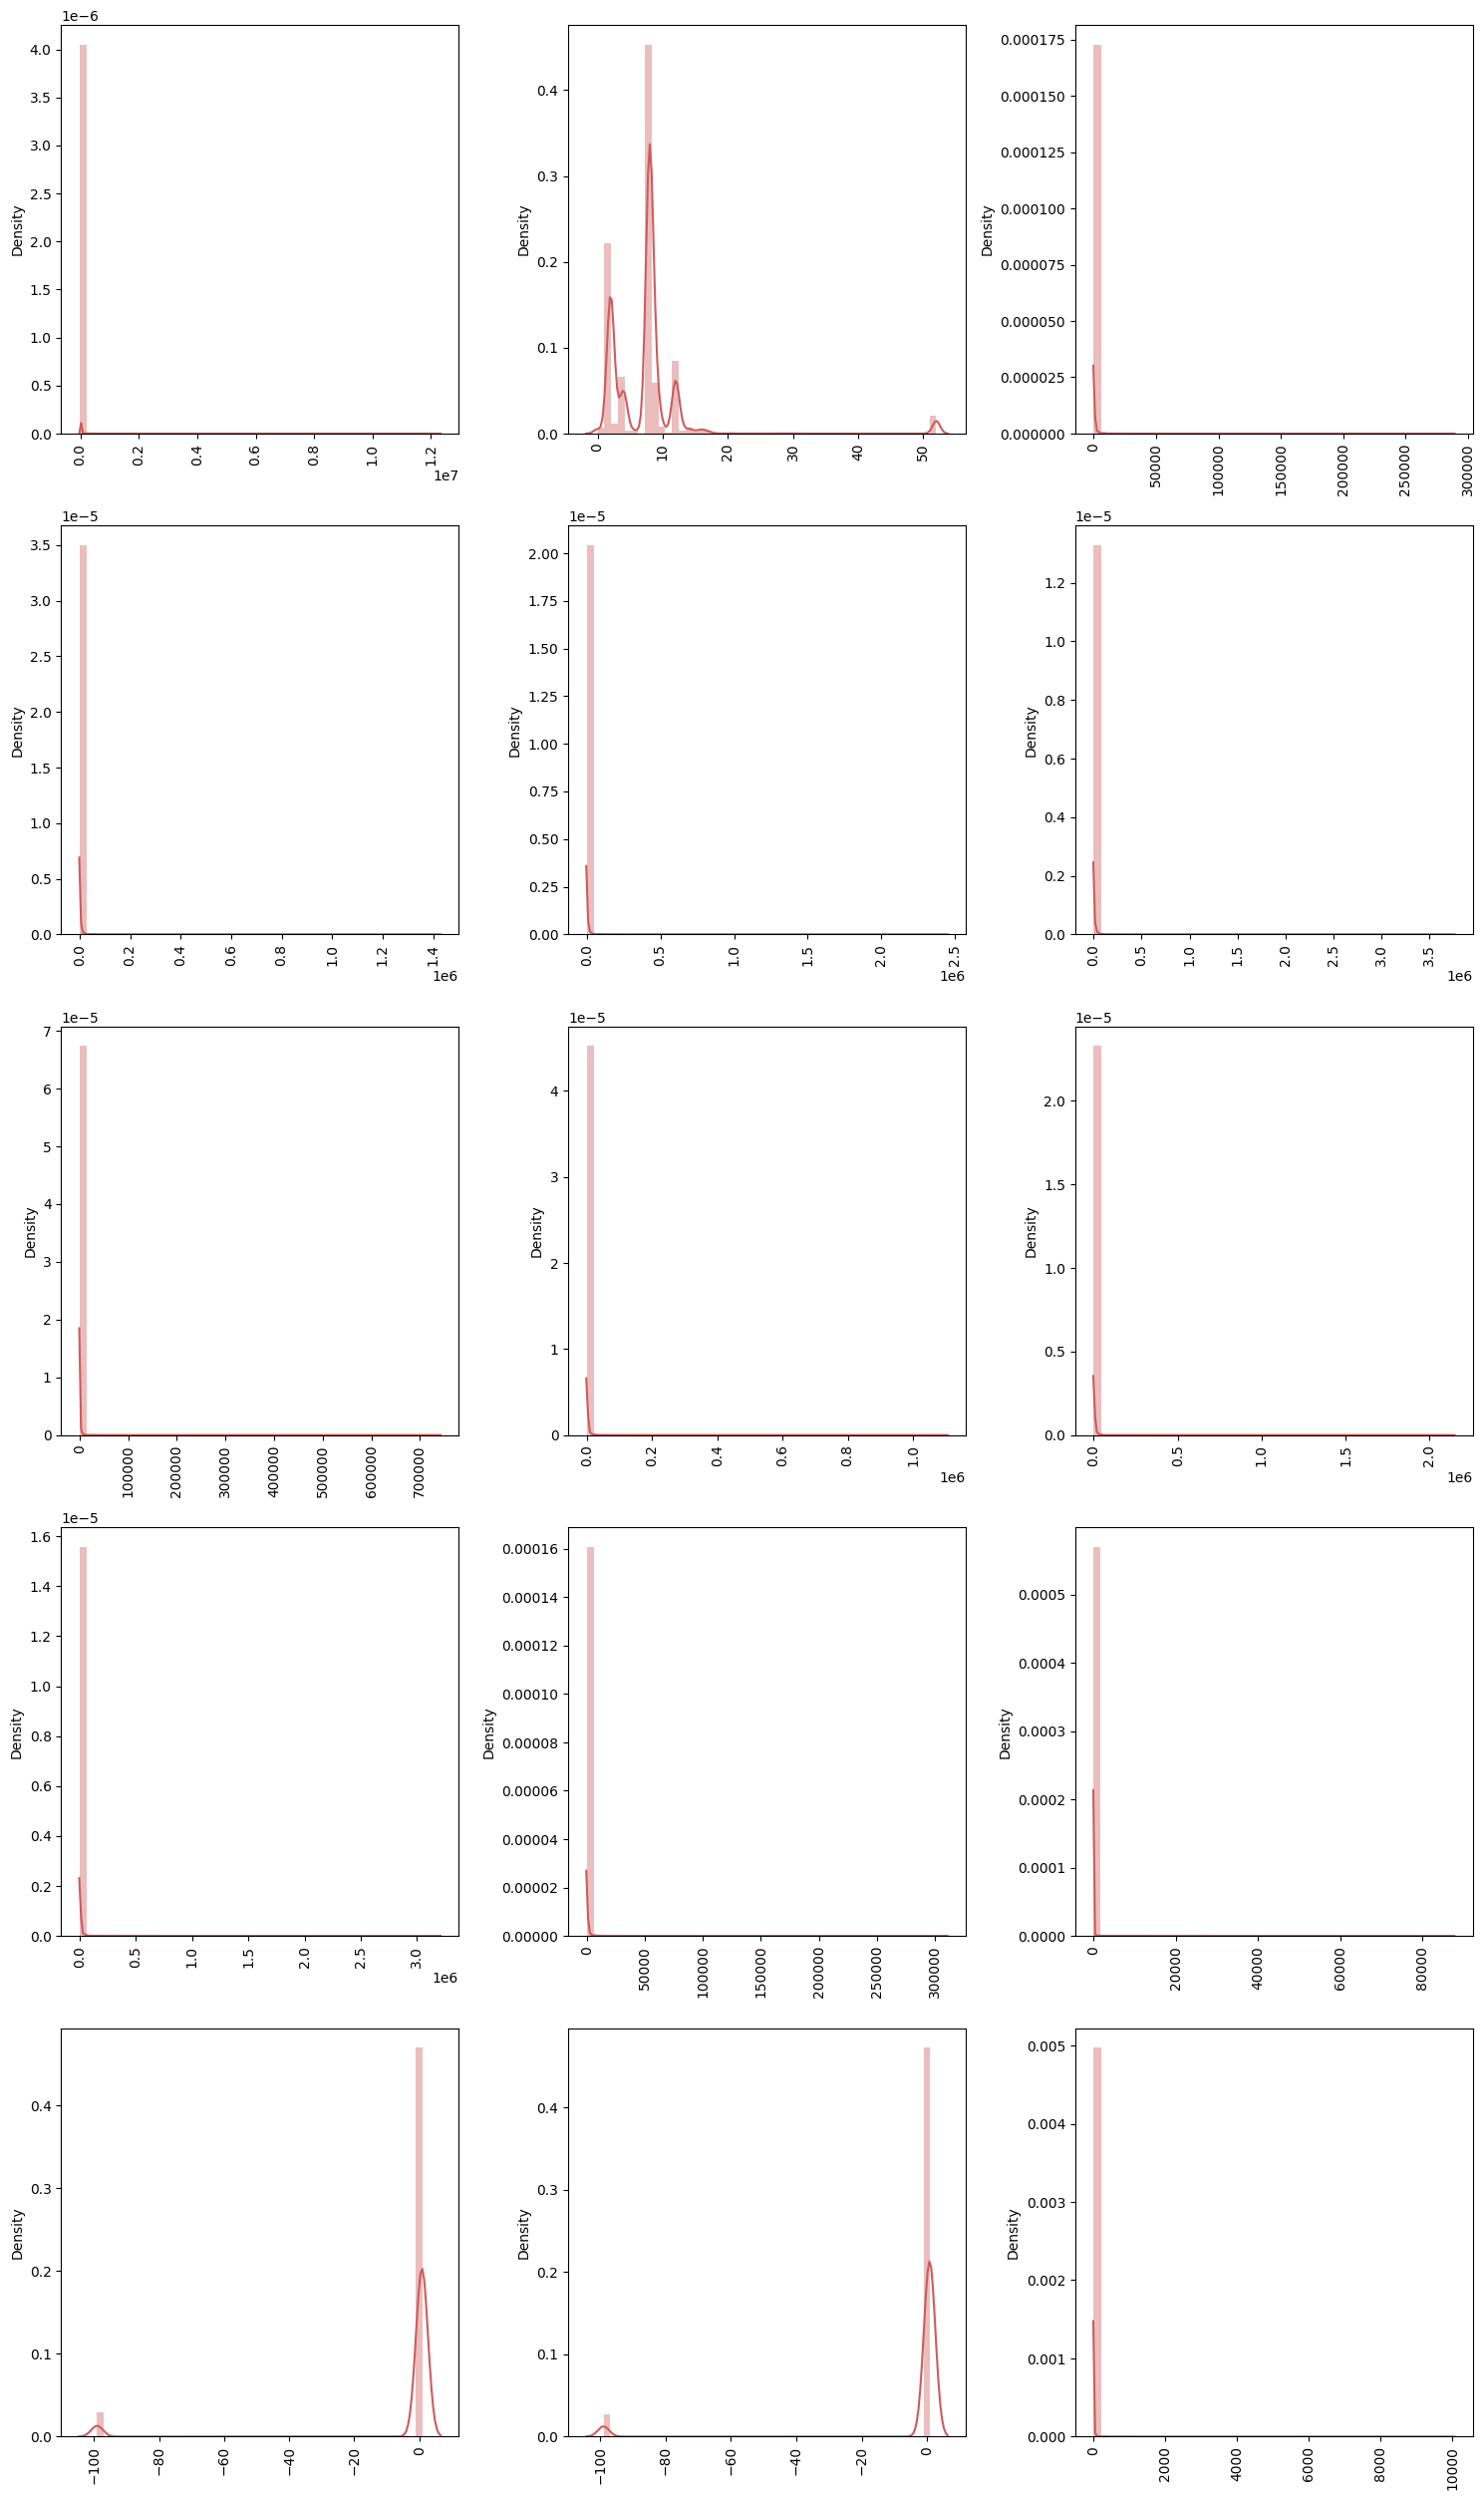

In [31]:
# Checking for the Univariate distribution

plt.figure(figsize=(15, 100))
for i, feature in enumerate(numerical_features):
    plt.subplot(20, 3, i+1)
    sns.distplot(x=dataset[feature], color='indianred')
    plt.xlabel=feature
    plt.ylabel='Density'
    plt.xticks(rotation=90)
    plt.tight_layout()


In [51]:
## checking distribution and outliers
def show_distribution(var_data,feature):

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(f"{feature}")
    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel(feature)

    # Add a title to the Figure
    fig.suptitle('Data Distribution')

    # Show the figure
    fig.show()



lead_time
Minimum:0.00
Mean:7.75
Median:8.00
Mode:8.00
Maximum:52.00

in_transit_qty
Minimum:0.00
Mean:63.71
Median:0.00
Mode:0.00
Maximum:288768.00

forecast_3_month
Minimum:0.00
Mean:266.77
Median:0.00
Mode:0.00
Maximum:1427612.00

forecast_6_month
Minimum:0.00
Mean:513.74
Median:0.00
Mode:0.00
Maximum:2446072.00

forecast_9_month
Minimum:0.00
Mean:750.86
Median:1.00
Mode:0.00
Maximum:3760840.00

sales_1_month
Minimum:0.00
Mean:82.98
Median:1.00
Mode:0.00
Maximum:741774.00

sales_3_month
Minimum:0.00
Mean:260.11
Median:5.00
Mode:0.00
Maximum:1104181.00

sales_6_month
Minimum:0.00
Mean:505.13
Median:10.00
Mode:0.00
Maximum:2145715.00

sales_9_month
Minimum:0.00
Mean:774.35
Median:15.00
Mode:0.00
Maximum:3204929.00

min_bank
Minimum:0.00
Mean:77.45
Median:1.00
Mode:0.00
Maximum:310427.00

pieces_past_due
Minimum:0.00
Mean:3.23
Median:0.00
Mode:0.00
Maximum:87689.00

perf_6_month_avg
Minimum:-99.00
Mean:-5.16
Median:0.85
Mode:1.00
Maximum:1.00

perf_12_month_avg
Minimum:-99.00
Mean:-4.6

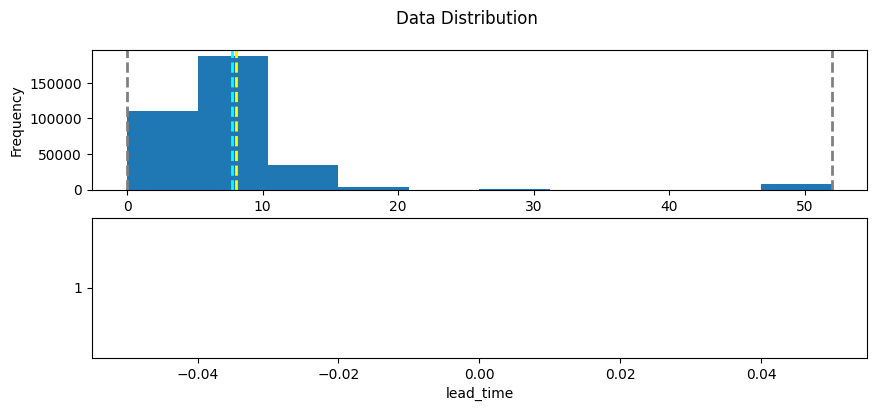

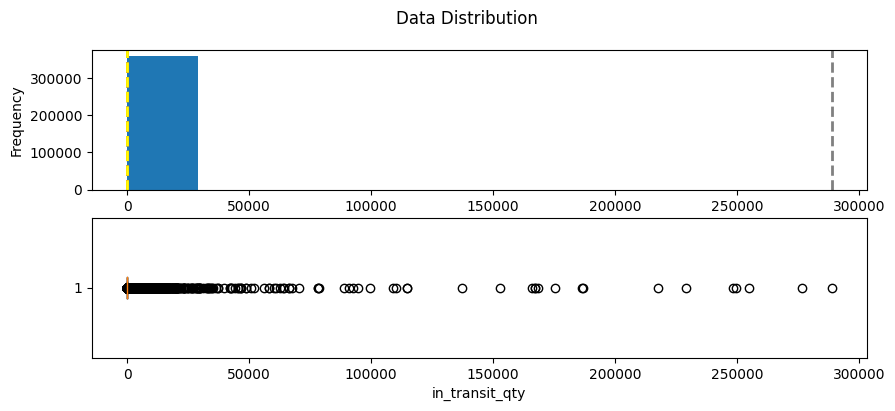

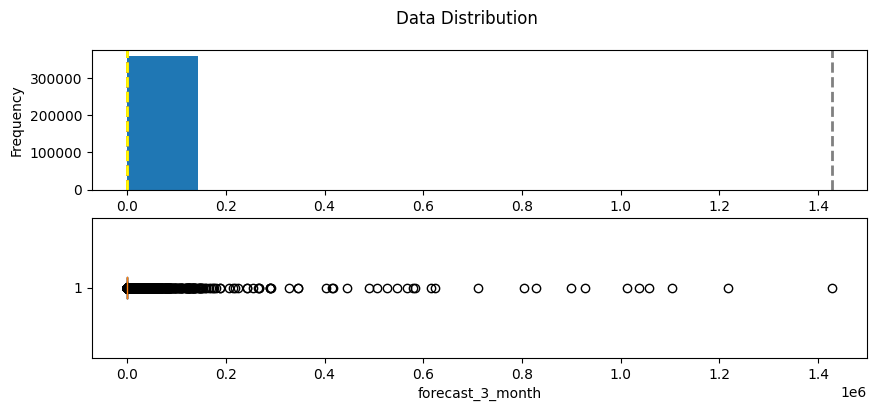

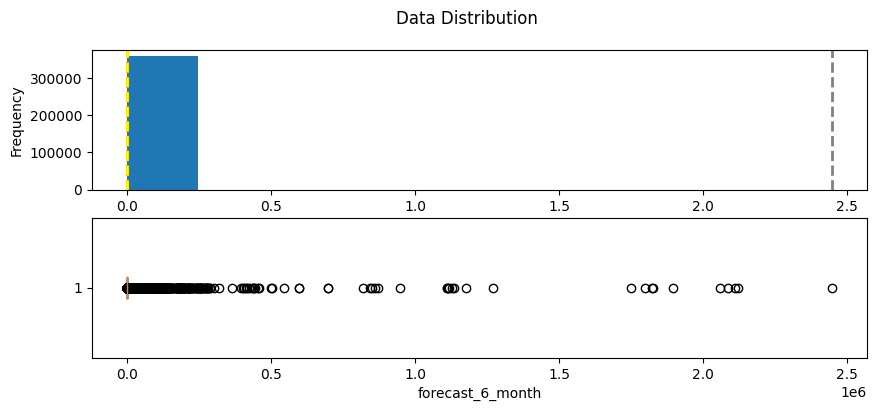

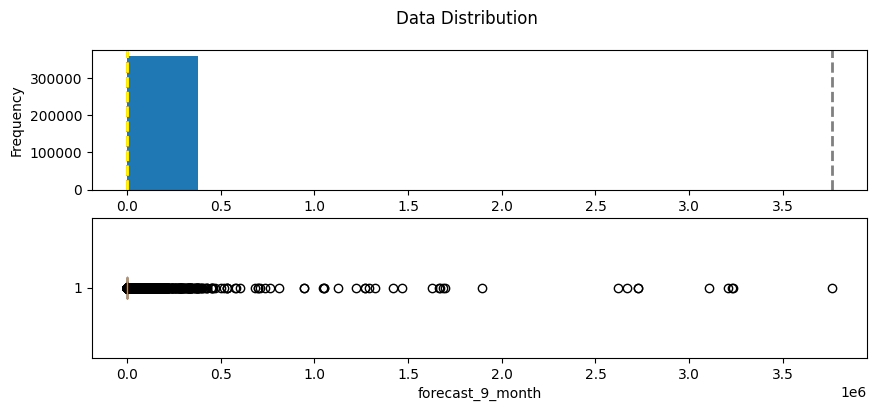

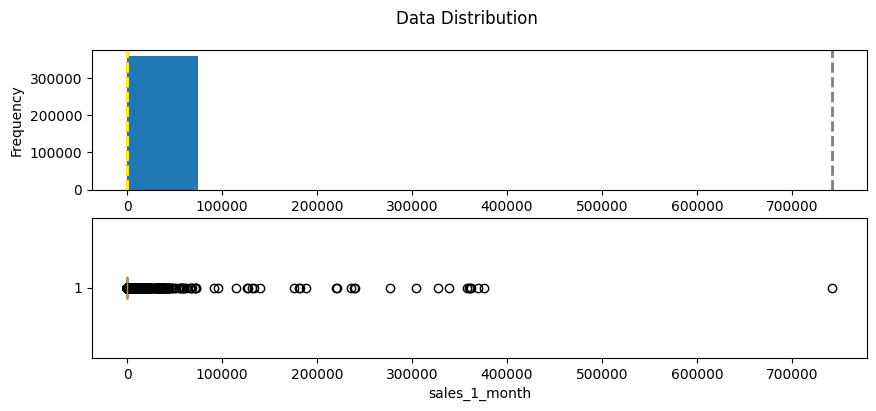

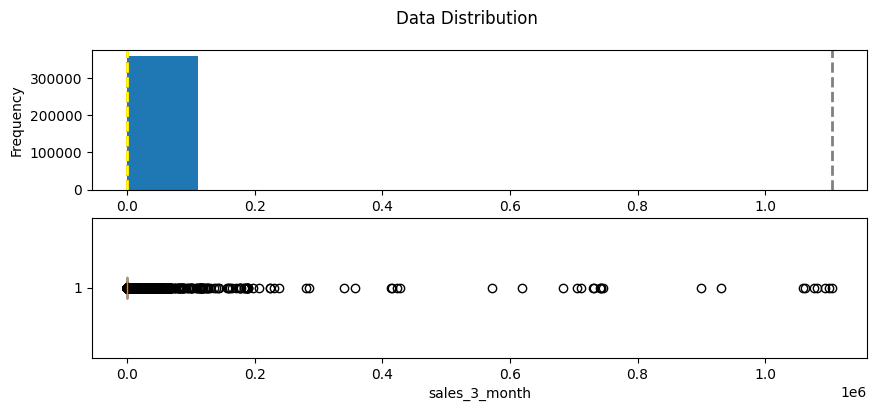

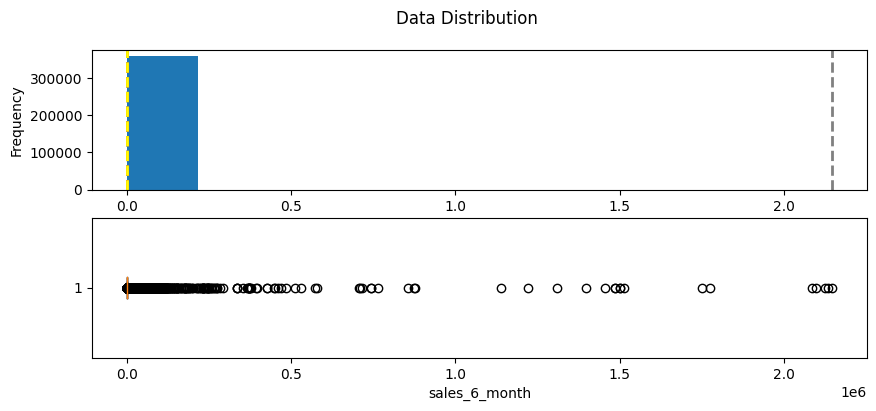

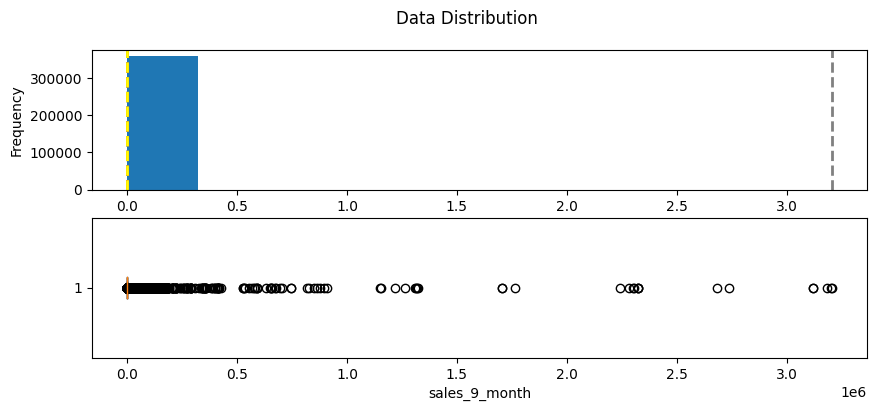

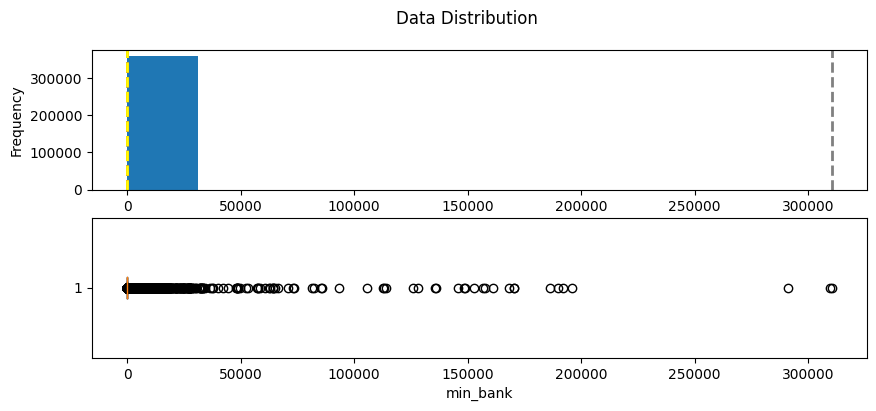

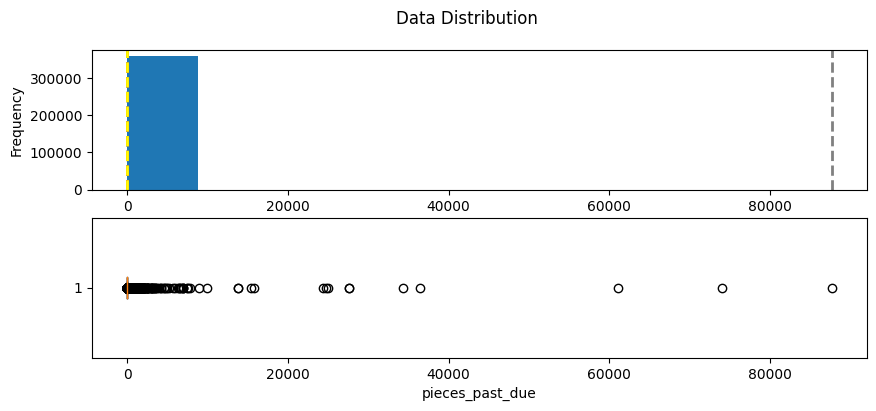

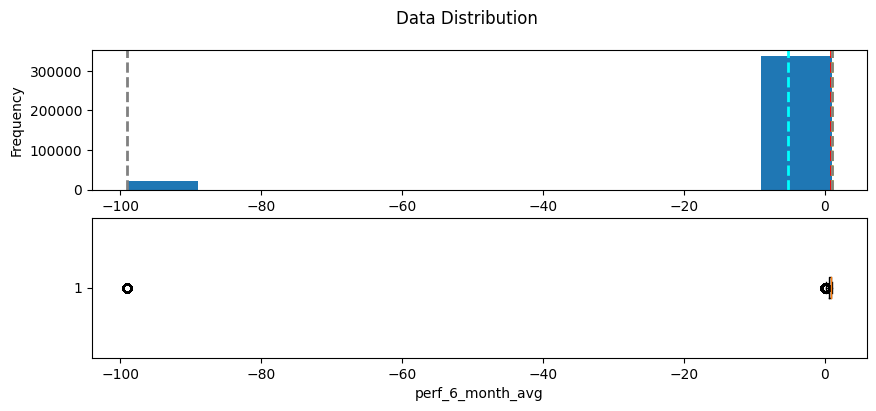

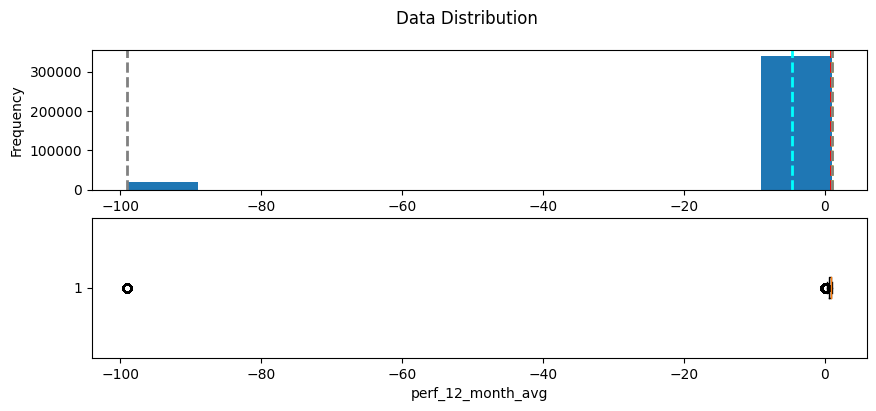

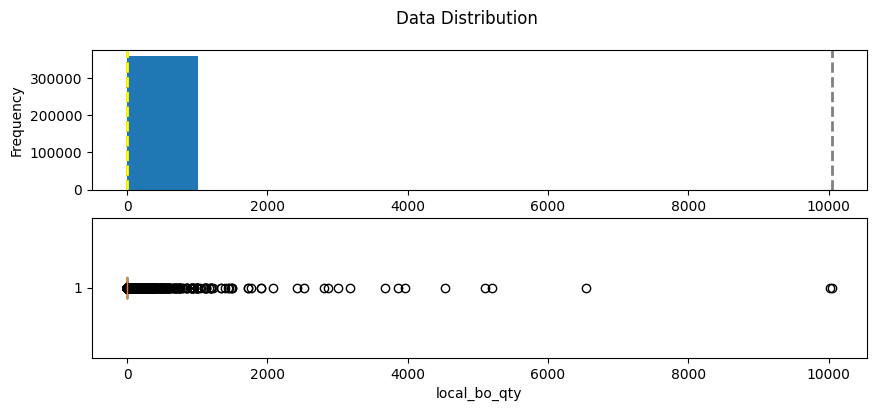

In [33]:
# Get the variable to examine

for feature in numerical_features[1:]:
    # Call the function
    show_distribution(dataset[feature],feature)

## Observation

1. We can observe there are many features that are not normally distributed.
2. Transformation of the data is not major importance as this is a classifaction problem.
3. We have many outliers in the Numerical Features can handle them using RobustScaler.
4. we can see that perf_6_month and perf_12_month has max value 1 and min value -99. Means the nan values filled by -99.

### HeatMap

<AxesSubplot: >

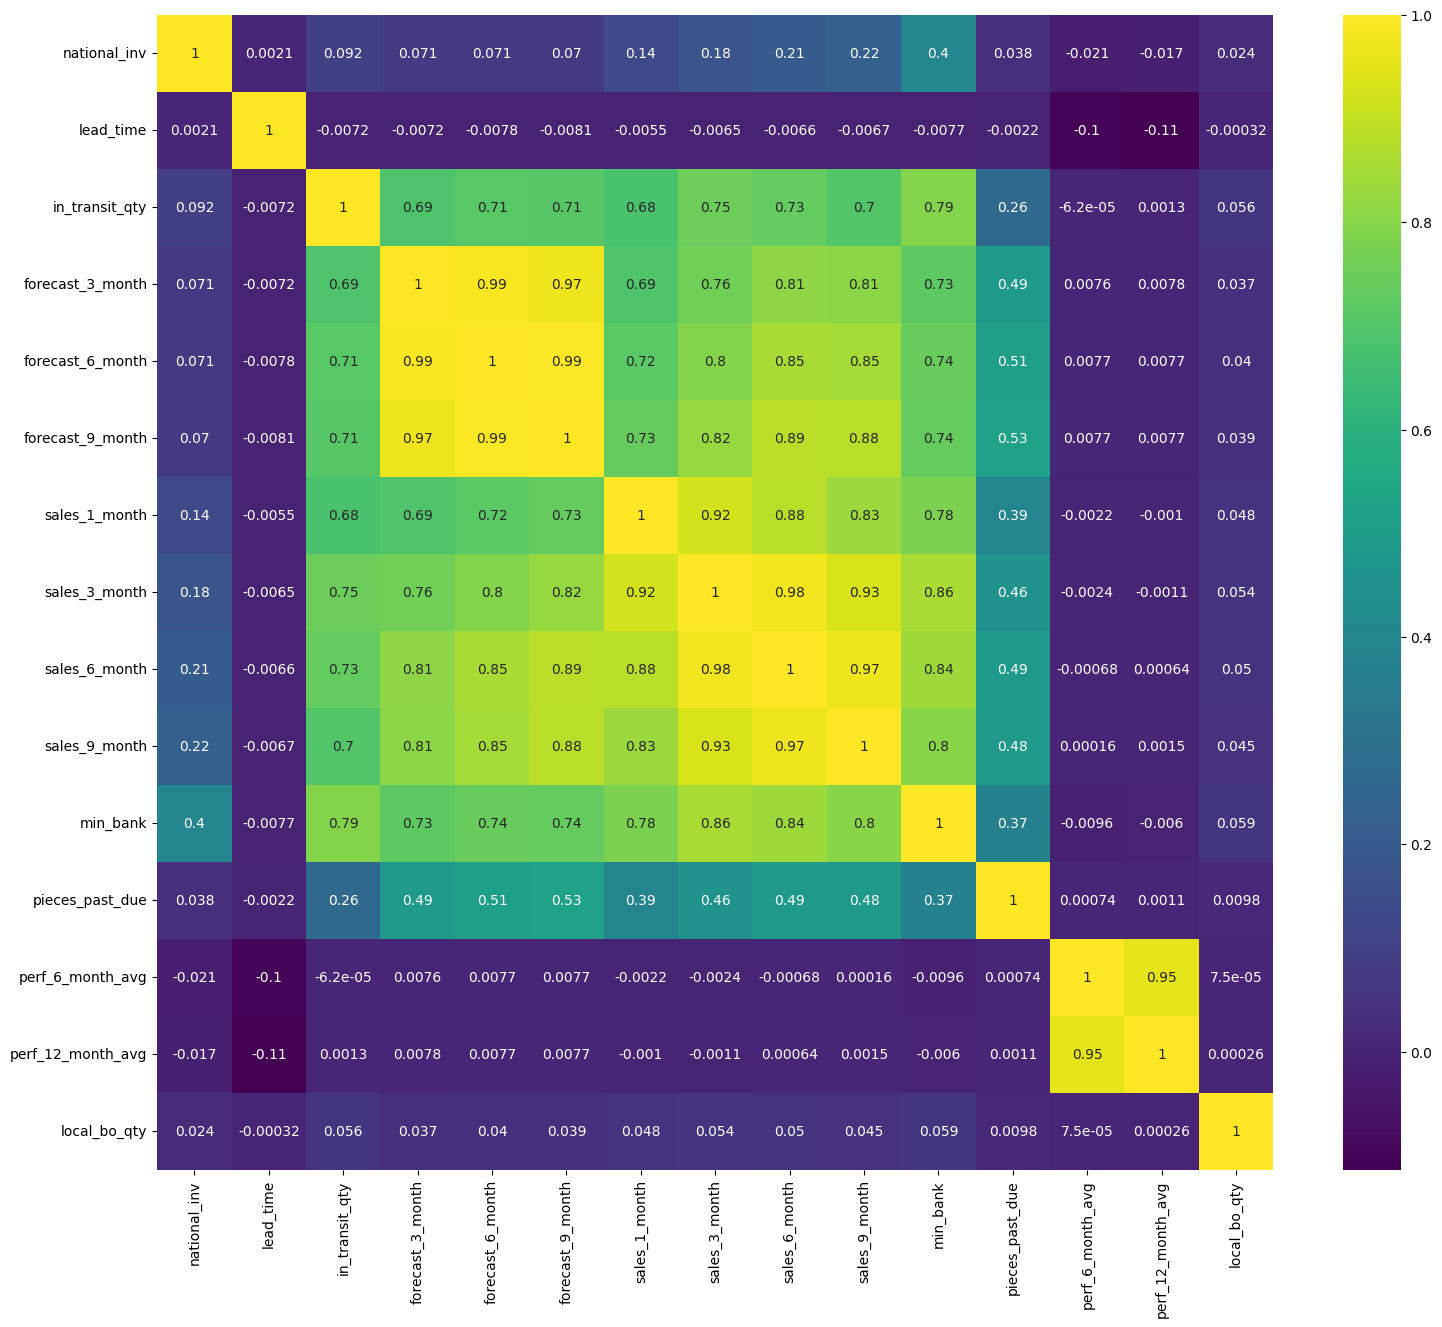

In [19]:
plt.figure(figsize=(18, 15))
sns.heatmap(dataset[numerical_features].corr(),annot=True,cmap='viridis')

## Observation

- perf_6_month_avg and perf_12_avg are 95% correlated to each other.
- forecast_3_month and forecast_6_month are 99% correlated to each other.
- perf_6_month_avg and perf_12_avg are negatively correlated with lead_time
- sales_1_month,sales_3_month,sales_6_month are highly correlated with each other.


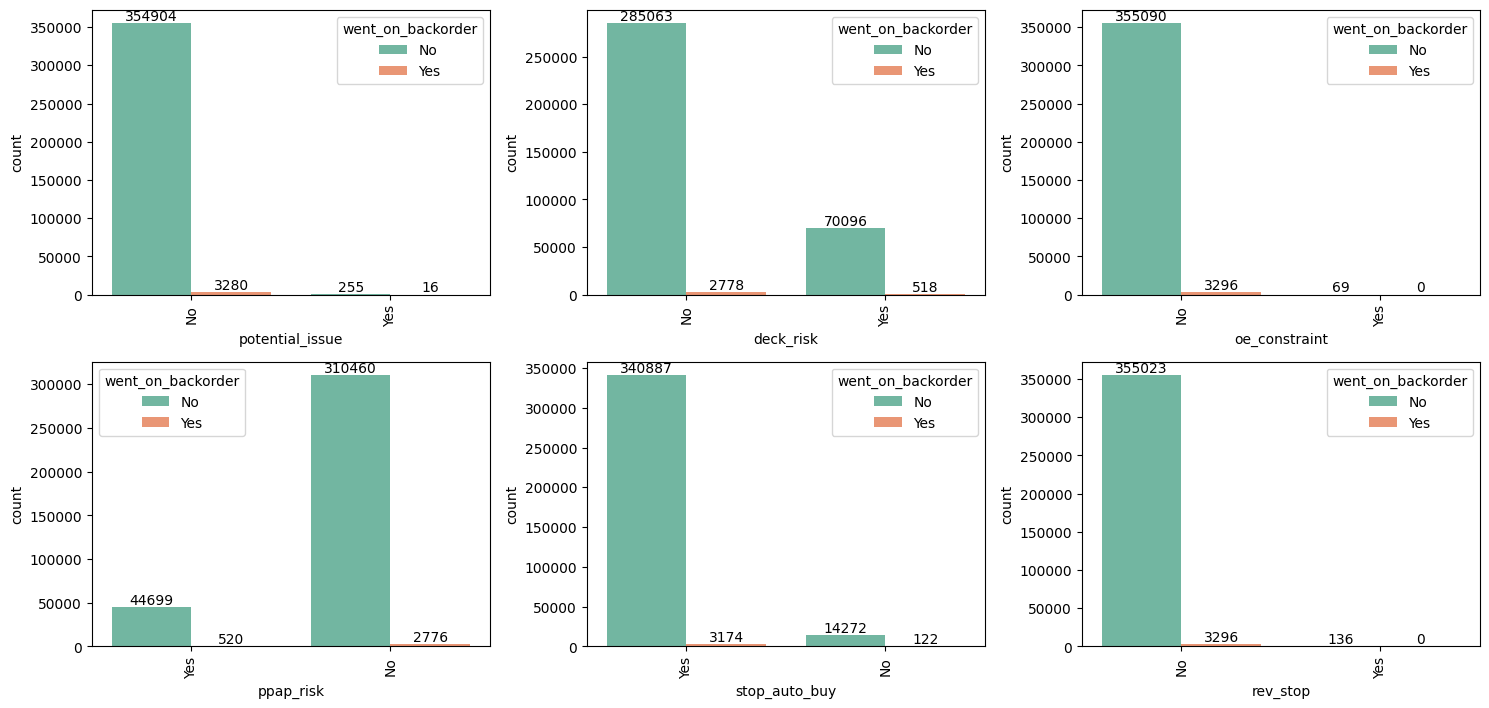

In [38]:
# plotting the categoricl features

plt.figure(figsize=(15, 70))
for i, feature in enumerate(categorical_features[:-1]):
    plt.subplot(20, 3, i+1)
    ax=sns.countplot(x=dataset[feature],palette='Set2',hue=dataset['went_on_backorder'])
    plt.xlabel = feature
    
    plt.ylabel = 'Frequency'
    plt.xticks(rotation=90)
    for i in ax.containers:
        ax.bar_label(i)
    plt.tight_layout()

### Observation
- when the potential_risk is `no` the items mostly not went on backorder
- when the oe_constraint is `no` the items mostly not went on backorder and same for rev_stop.


### Interpreting Target Feature

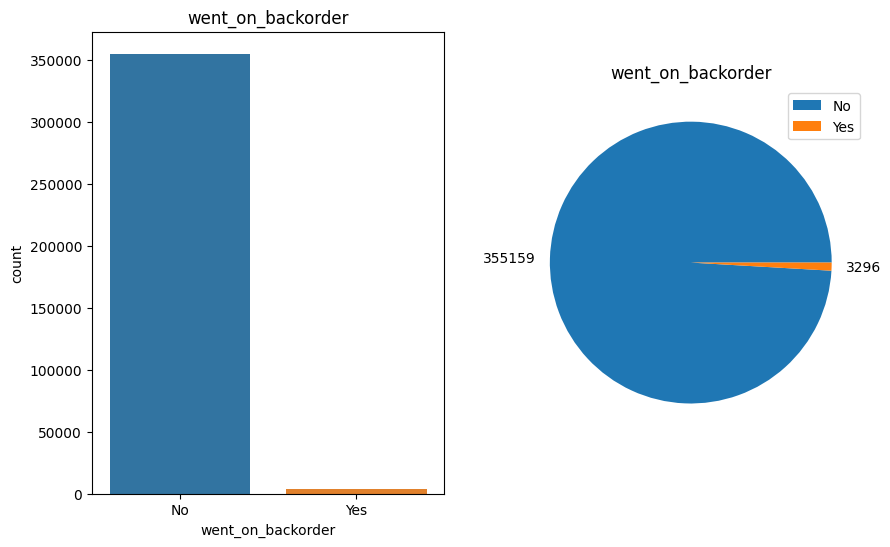

In [12]:
## creating a figure for 2 subplots (1 row 2 columns)

fig, ax = plt.subplots(1,2,figsize=(10,6))

# ploting barplot for target feature

sns.countplot(x=dataset['went_on_backorder'],ax=ax[0])
ax[0].set_title('went_on_backorder')

# plotting piechart for target feature
values = dataset['went_on_backorder'].value_counts()
ax[1].pie(values,labels=values)
ax[1].set_title('went_on_backorder')
ax[1].legend(values.keys().tolist())

plt.show()




### Observation
1. The target classes are **highly imbalanced**
2. Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
3. If the imbalanced data is not treated, then this will degrade the performance of the classifier model.
Hence we should handle imbalanced data with certain methods.

#### How to handle Imbalance Data ?

1. **Resampling data** is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.

2. **SMOTE**: *Synthetic Minority Oversampling Technique*
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of - classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques

## Summary of Exploratory data analysis
 - Only lead_time has high nan values.
 - We can observe there are many features that are not normally distributed.
 -  Transformation of the data is not major importance as this is a classifaction problem.
 - We have many outliers in the Numerical Features can handle them using RobustScaler.
 - we can see that perf_6_month and perf_12_month has max value 1 and min value -99. Means the nan values filled by -99. Needs to handle the value
 - perf_6_month_avg and perf_12_avg are 95% correlated to each other.
 - forecast_3_month and forecast_6_month are 99% correlated to each other.
 - perf_6_month_avg and perf_12_avg are negatively correlated with lead_time
 - sales_1_month,sales_3_month,sales_6_month are highly correlated with each other.
 - when the potential_risk is `no` the items mostly not went on backorder
 - when the oe_constraint is `no` the items mostly not went on backorder and same for rev_stop. 
 - The target classes are **highly imbalanced**
 - Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated, then this will degrade the performance of the classifier model.
Hence we should handle imbalanced data with certain methods.
 

#### Creating the function to Evaluate the model

In [21]:
def evaluate_classification(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 =  f1_score(y_true,y_pred)
    roc_auc = roc_auc_score(y_true,y_pred)
     

    return accuracy,precision,recall,f1,roc_auc

In [22]:
def evaluate_models(X,y,models):
    """
    This model Takes the Independent and Target Features
    and Performs Model fitting.
    Returns the Performance of the models
    """
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

    result=pd.DataFrame(columns=["modelname","model_train_accuracy","model_train_precision","model_train_recall","model_train_f1","model_train_roc_auc",
    "model_test_accuracy","model_test_precision","model_test_recall","model_test_f1","model_test_roc_auc"])

    conf_matrix_scores={}

    for i in range(len(list(models))):
        model = list(models.values())[i]
        # Fitting the model
        model.fit(X_train,y_train)

        # prediction
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        # Training accuracy 
        model_train_accuracy,model_train_precision,model_train_recall,model_train_f1,model_train_roc_auc = evaluate_classification(y_train,train_pred)
         
 
        # Testing accuracy
        model_test_accuracy,model_test_precision,model_test_recall,model_test_f1,model_test_roc_auc = evaluate_classification(y_test,test_pred)
        conf_matrix_scores[list(models.keys())[i]]=confusion_matrix(y_test,test_pred)

        scores_dict = {
            "modelname":list(models.keys())[i],
            "model_train_accuracy":model_train_accuracy,
            "model_train_precision":model_train_precision,
            "model_train_recall":model_train_recall
            ,"model_train_f1":model_train_f1,
            "model_train_roc_auc":model_train_roc_auc,
            "model_test_accuracy":model_test_accuracy,
            "model_test_precision":model_test_precision,
            "model_test_recall":model_test_recall,
            "model_test_f1":model_test_f1,
            "model_test_roc_auc":model_test_roc_auc
        }

        result=result.append(scores_dict,ignore_index=True)
    
    

    
    return result.sort_values(by=["model_test_accuracy"],ascending=False),conf_matrix_scores


In [23]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

## Experiment-1
  - Strategy with dropping the null values as we have huge amount of data it will not affect our model by dropping them.
  - Handle Imablance Data(Target Fearure) and Not Performing any Outlier Treatment

In [34]:
# dropping null values
df_copy=dataset.copy()

In [35]:
## Shape of data after dropping

df_copy.shape

(358455, 22)

In [36]:
## Handling the unusual value in  perf_6_month and perf_12_month 
df_copy['perf_6_month_avg'].replace({-99:np.nan},inplace=True)
df_copy['perf_12_month_avg'].replace({-99:np.nan},inplace=True)

In [37]:
df_copy=df_copy.dropna()
print(df_copy.shape)

(337046, 22)


In [38]:
## Encoding Categorical features
def encoding_categorical_variable(feature,df):
    df[feature].replace({"No":0,'Yes':1},inplace=True)
    return df

In [39]:
for feature in categorical_features:
    df_copy = encoding_categorical_variable(feature,df_copy)

#### Seperating Independent and Target features

In [40]:
X =  df_copy.drop('went_on_backorder',axis=1)

y = df_copy.went_on_backorder

#####  Handle Imablance Data(Target Fearure)


 **SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
 - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
 
 - To add new data of minority class
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - To remove the tomek links of the majority class
 1. Choose random data from the majority class.
 2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [41]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
X_res,y_res = smt.fit_resample(X,y)
print('Original dataset shape \n',y.value_counts())
print('\nAfter resampling dataset shape \n ',y_res.value_counts())

Original dataset shape 
 0    333848
1      3198
Name: went_on_backorder, dtype: int64

After resampling dataset shape 
  0    333794
1    333794
Name: went_on_backorder, dtype: int64


In [42]:
## Model Bulding

report0,conf_mat0=evaluate_models(X_res,y_res,models)
report0

,modelname,model_train_accuracy,model_train_precision,model_train_recall,model_train_f1,model_train_roc_auc,model_test_accuracy,model_test_precision,model_test_recall,model_test_f1,model_test_roc_auc
0,Random Forest,0.999890,0.999884,0.999897,0.999890,0.999890,0.994544,0.993051,0.996090,0.994568,0.994539
1,Decision Tree,0.999890,0.999987,0.999794,0.999890,0.999890,0.986283,0.983530,0.989210,0.986362,0.986274
4,K-Neighbors Classifier,0.978568,0.959422,0.999342,0.978975,0.978598,0.970509,0.945446,0.998823,0.971402,0.970427
2,Gradient Boosting,0.929666,0.922779,0.937592,0.930127,0.929678,0.928803,0.922300,0.936952,0.929569,0.928780
5,AdaBoost Classifier,0.902080,0.896626,0.908639,0.902592,0.902089,0.901509,0.895987,0.909126,0.902509,0.901487
3,Logistic Regression,0.822173,0.825467,0.816467,0.820942,0.822165,0.823054,0.828165,0.816560,0.822321,0.823073


In [43]:
conf_mat0

{'Random Forest': array([[109063,    770],
        [   432, 110040]]),
 'Decision Tree': array([[108003,   1830],
        [  1192, 109280]]),
 'Gradient Boosting': array([[101113,   8720],
        [  6965, 103507]]),
 'Logistic Regression': array([[91116, 18717],
        [20265, 90207]]),
 'K-Neighbors Classifier': array([[103466,   6367],
        [   130, 110342]]),
 'AdaBoost Classifier': array([[ 98174,  11659],
        [ 10039, 100433]])}

## Strategy - 2 Performing Robust Scaling and Handling the imbalance Data and imputing null values null values with median

In [44]:
df_copy = dataset.copy()

In [45]:
## Handling the unusual value in  perf_6_month and perf_12_month 
df_copy['perf_6_month_avg'].replace({-99:np.nan},inplace=True)
df_copy['perf_12_month_avg'].replace({-99:np.nan},inplace=True)

In [46]:
from sklearn.preprocessing import OneHotEncoder
o = OneHotEncoder(drop='if_binary',sparse_output=False)
df_copy[categorical_features]=o.fit_transform(df_copy[categorical_features])

In [47]:
X = df_copy.drop('went_on_backorder',axis=1)
y = df_copy.went_on_backorder

In [48]:
median_robust_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [49]:
X_transfomed = median_robust_pipeline.fit_transform(X)

lead_time
Minimum:-0.23
Mean:0.06
Median:0.00
Mode:0.00
Maximum:1.00

in_transit_qty
Minimum:-0.71
Mean:-0.09
Median:0.00
Mode:0.00
Maximum:0.00

forecast_3_month
Minimum:-1.50
Mean:0.02
Median:0.00
Mode:0.00
Maximum:1.00

forecast_6_month
Minimum:-1.04
Mean:-0.09
Median:0.00
Mode:0.00
Maximum:1.00

forecast_9_month
Minimum:-1.00
Mean:-0.04
Median:0.00
Mode:0.00
Maximum:1.00

sales_1_month
Minimum:-0.20
Mean:0.02
Median:0.00
Mode:0.00
Maximum:0.57

sales_3_month
Minimum:-1.50
Mean:0.02
Median:0.00
Mode:0.00
Maximum:1.19

sales_6_month
Minimum:-0.20
Mean:0.01
Median:0.00
Mode:0.00
Maximum:0.52

sales_9_month
Minimum:-2.17
Mean:-0.23
Median:0.00
Mode:0.00
Maximum:0.00

min_bank
Minimum:-0.23
Mean:-0.00
Median:0.00
Mode:0.00
Maximum:0.43

pieces_past_due
Minimum:-1.04
Mean:-0.07
Median:0.00
Mode:0.00
Maximum:1.00

perf_6_month_avg
Minimum:-3.30
Mean:7.41
Median:1.00
Mode:0.00
Maximum:38.00

perf_12_month_avg
Minimum:-2.88
Mean:-0.29
Median:0.00
Mode:0.00
Maximum:0.00

local_bo_qty
Minimum

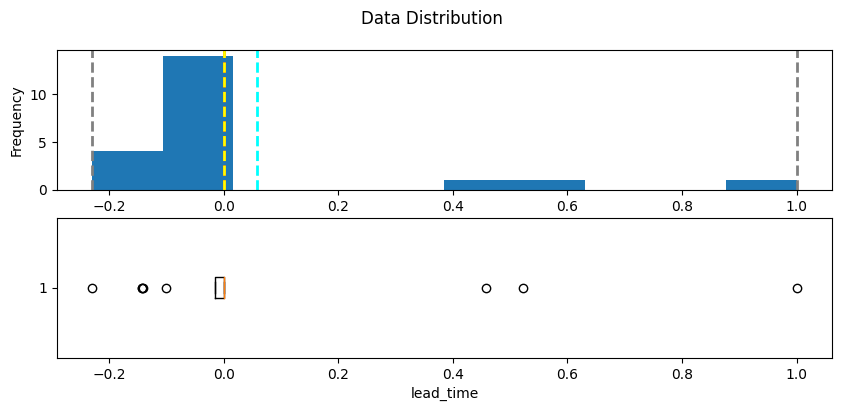

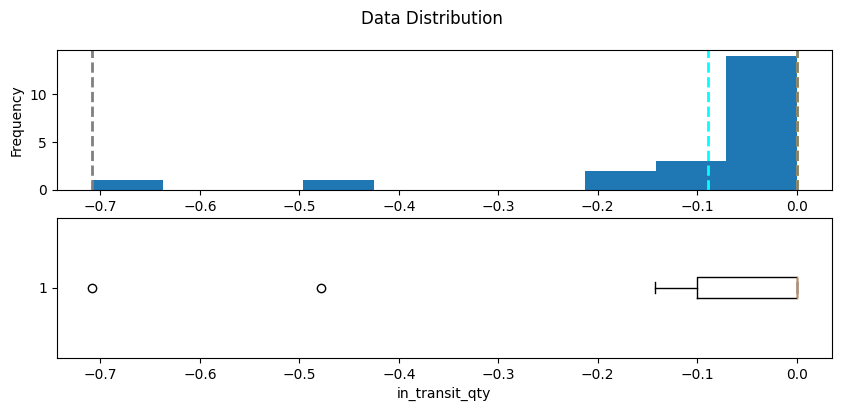

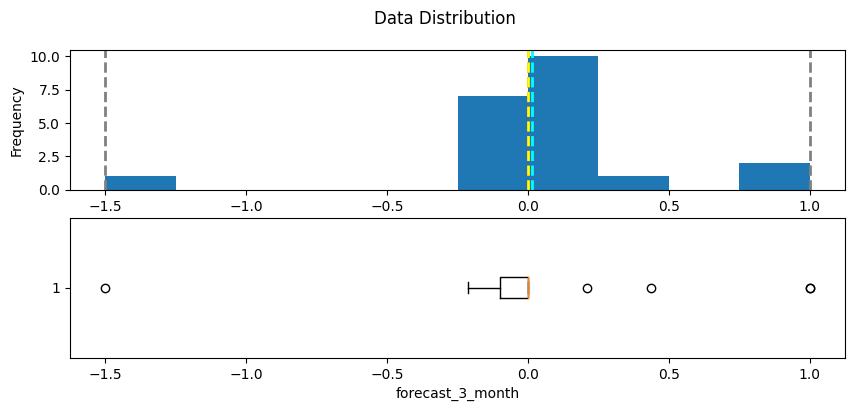

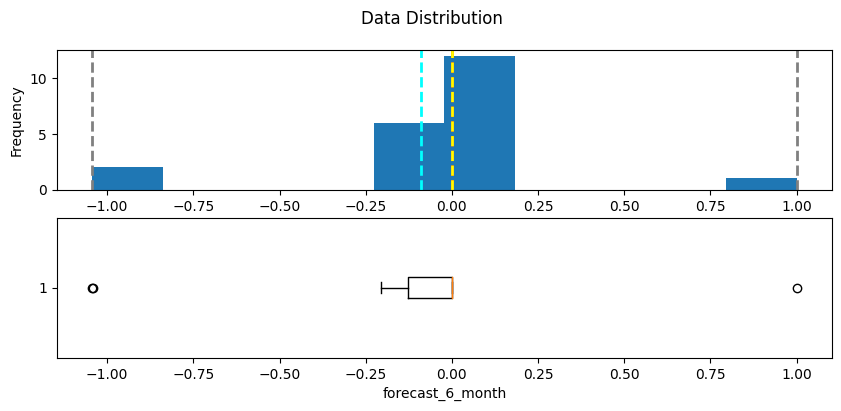

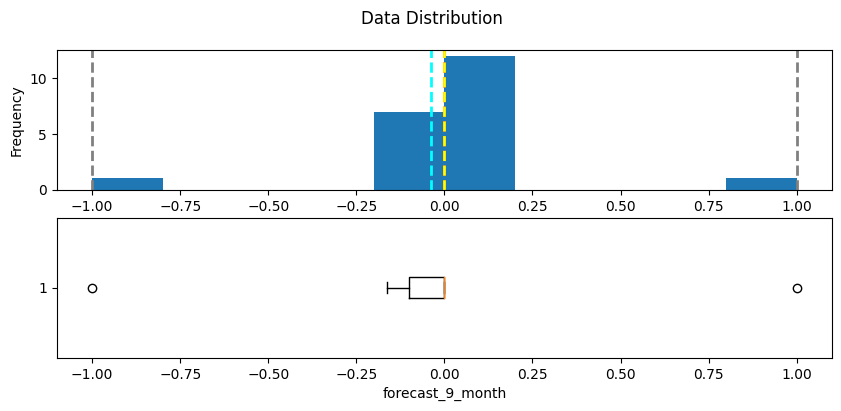

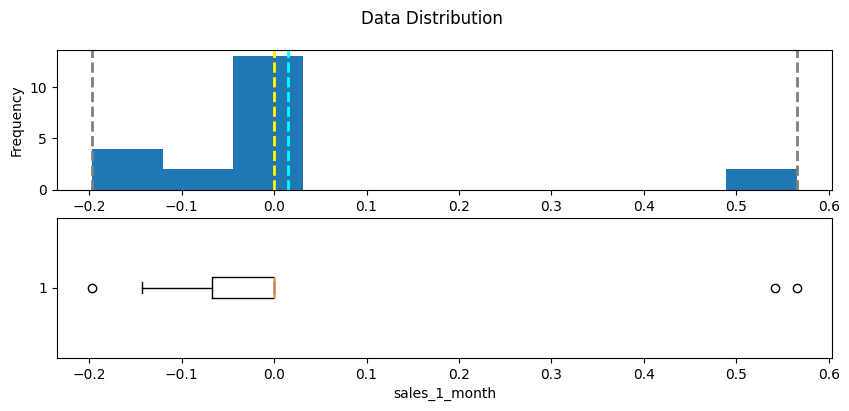

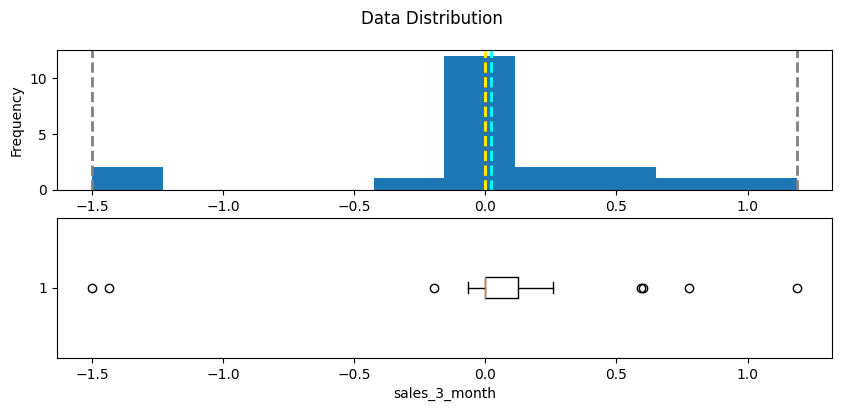

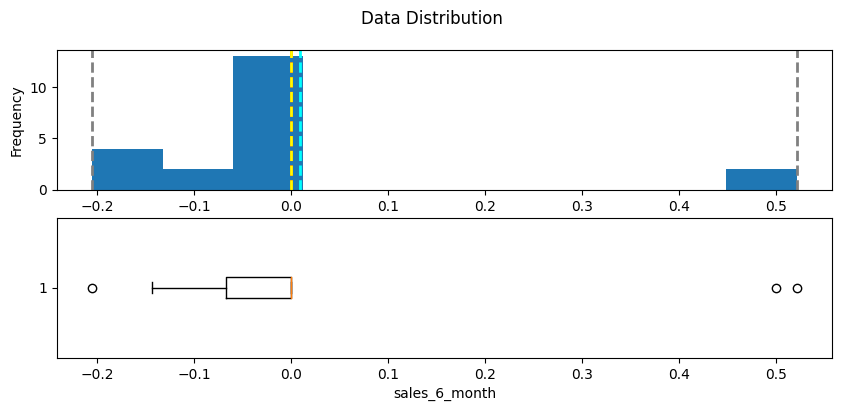

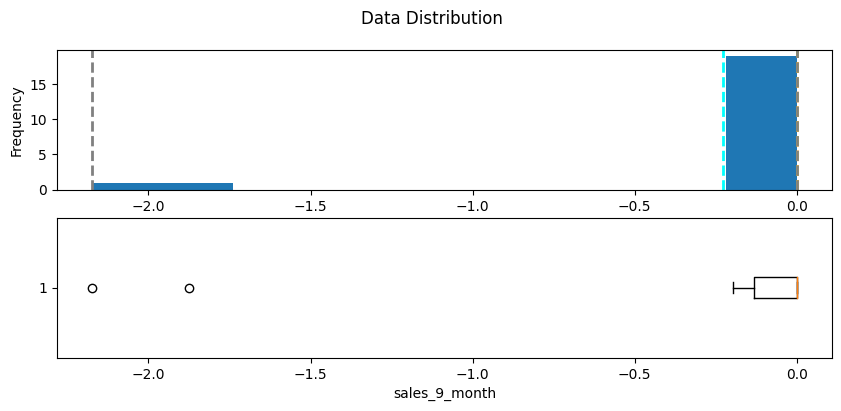

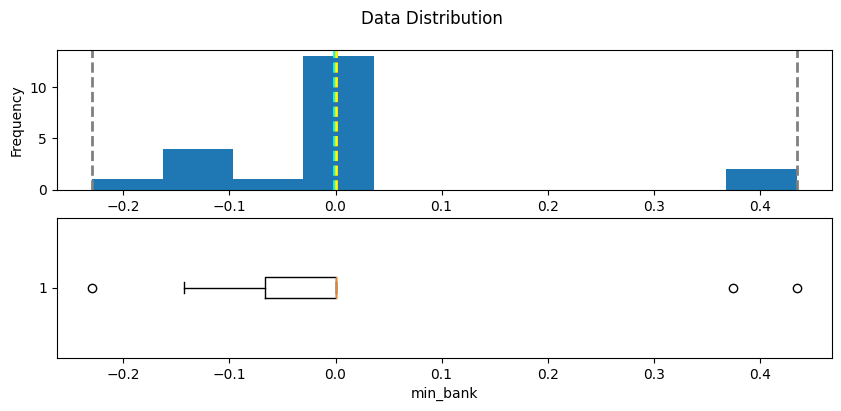

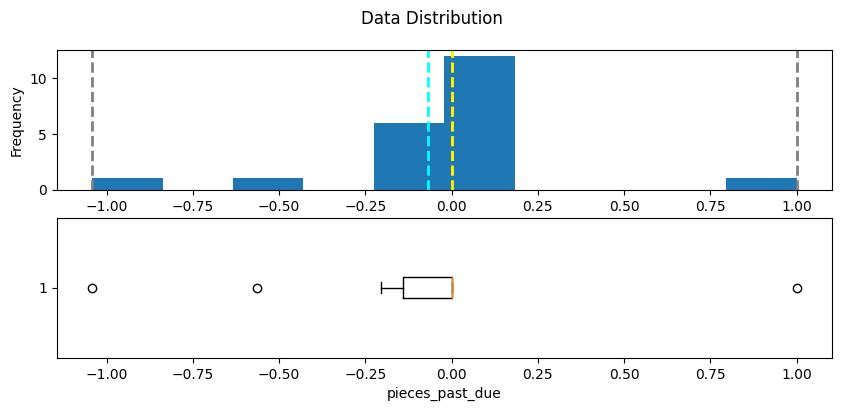

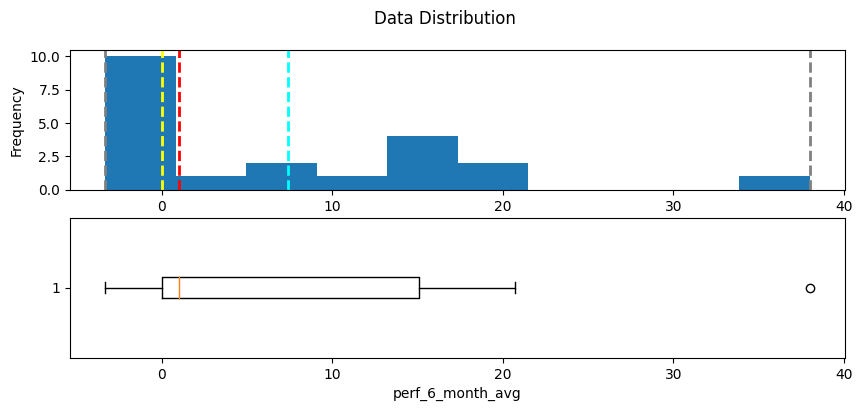

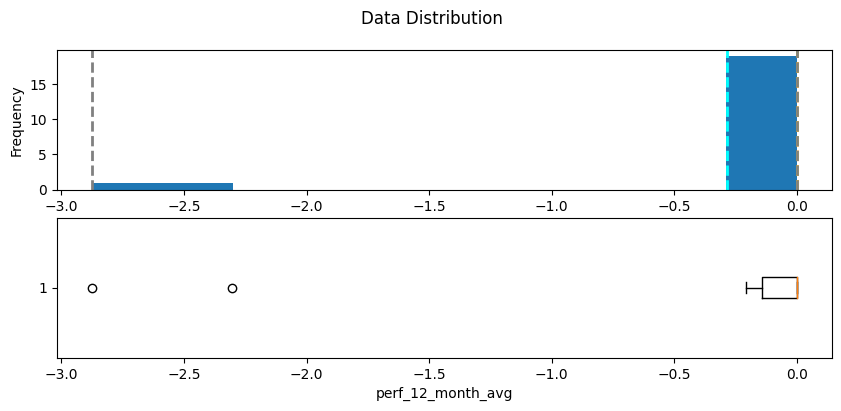

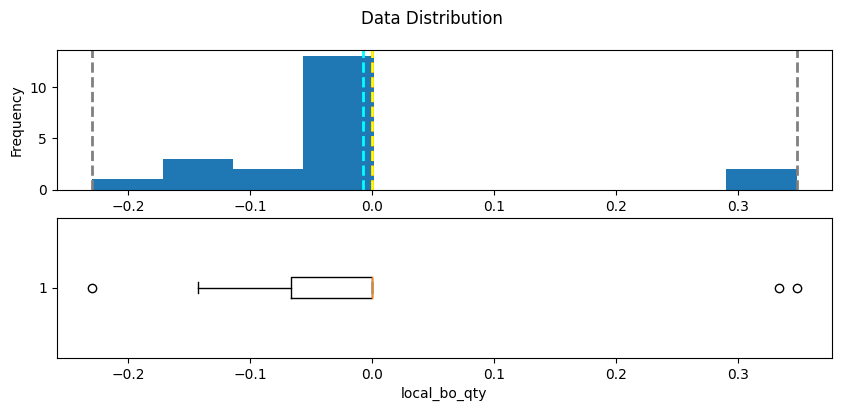

In [52]:
## After Scaling Checking the distribution

for i,feature in enumerate(numerical_features[1:]):
    show_distribution(pd.Series(X_transfomed[i]),feature)

##### We can observe the most of the ouliers are removed

In [53]:
## Resampling the Data

smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
X_res,y_res = smt.fit_resample(X_transfomed,y)
print('Original dataset shape \n',y.value_counts())
print('\nAfter resampling dataset shape \n ',y_res.value_counts())

Original dataset shape 
 0.0    355159
1.0      3296
Name: went_on_backorder, dtype: int64

After resampling dataset shape 
  0.0    355113
1.0    355113
Name: went_on_backorder, dtype: int64


In [54]:
## Model Bulding

report,conf_mat=evaluate_models(X_res,y_res,models)
report

,modelname,model_train_accuracy,model_train_precision,model_train_recall,model_train_f1,model_train_roc_auc,model_test_accuracy,model_test_precision,model_test_recall,model_test_f1,model_test_roc_auc
0,Random Forest,0.999874,0.999933,0.999815,0.999874,0.999874,0.995315,0.994327,0.996313,0.995319,0.995315
1,Decision Tree,0.999874,1.000000,0.999748,0.999874,0.999874,0.987439,0.984863,0.990091,0.987470,0.987439
4,K-Neighbors Classifier,0.977777,0.957728,0.999681,0.978254,0.977775,0.969762,0.943722,0.999095,0.970620,0.969766
2,Gradient Boosting,0.926210,0.914317,0.940574,0.927260,0.926209,0.925457,0.913748,0.939584,0.926486,0.925459
5,AdaBoost Classifier,0.900286,0.888139,0.915950,0.901830,0.900285,0.900288,0.887611,0.916609,0.901877,0.900290
3,Logistic Regression,0.704992,0.680751,0.772125,0.723565,0.704987,0.705374,0.681816,0.770003,0.723231,0.705383


In [55]:
conf_mat

{'Random Forest': array([[116538,    666],
        [   432, 116739]]),
 'Decision Tree': array([[115421,   1783],
        [  1161, 116010]]),
 'Gradient Boosting': array([[106812,  10392],
        [  7079, 110092]]),
 'Logistic Regression': array([[75100, 42104],
        [26949, 90222]]),
 'K-Neighbors Classifier': array([[110223,   6981],
        [   106, 117065]]),
 'AdaBoost Classifier': array([[103605,  13599],
        [  9771, 107400]])}